In [1]:
%matplotlib inline

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import datetime as dt
import dateutil.parser

In [2]:
def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = dt.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

In [3]:
def speed_to_pace(speed):
    miuntes, seconds = divmod(100 / (6 * speed), 1)
    seconds *= 60
    return (miuntes, seconds)

In [4]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/APE_runs_oct26-mar22"
window_size_half = 3
w_dist = np.array([0., 0.25, 0.5, 0.75, 1.])
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
Datasets_all = []
ds_mid1 = []
ds_mid2 = []
ds_mid3 = []
ds_mid4 = []

os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]                              # time reference set to 0
      
    if (ds[:,2].max() > 10000) == (ds[:,2].max() < 13000):
        ds = pd.DataFrame(ds,columns=colnames)
        slope = np.array([])
        pace = []
        
        for i in ds.index:
            index = np.arange(i - window_size_half + 1, i + window_size_half + 1)
            index = index[(index >= 0) & (index < len(ds))]
            dataset_part = ds[['distance','elevation']].iloc[index].dropna()

            regr = lm.LinearRegression()
            regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
            
            slope = np.append(slope,regr.coef_)

        dataset_new = ds.drop(['time','elevation','HR'], axis=1)
        dataset_new['slope'] = slope
        

        ds_mid1.append(dataset_new.query('(distance >= %f) and (distance < %f)'
                    % (dataset_new.distance.iloc[-1]*w_dist[0], dataset_new.distance.iloc[-1]*w_dist[1])))
        ds_mid2.append(dataset_new.query('(distance >= %f) and (distance < %f)'
                    % (dataset_new.distance.iloc[-1]*w_dist[1], dataset_new.distance.iloc[-1]*w_dist[2])))
        ds_mid3.append(dataset_new.query('(distance >= %f) and (distance < %f)'
                    % (dataset_new.distance.iloc[-1]*w_dist[2], dataset_new.distance.iloc[-1]*w_dist[3])))
        ds_mid4.append(dataset_new.query('(distance >= %f) and (distance <= %f)' 
                    % (dataset_new.distance.iloc[-1]*w_dist[3], dataset_new.distance.iloc[-1]*w_dist[4])))

        Datasets_all.append(dataset_new)
len(Datasets_all)

7

In [5]:
def profile2D(data_in, slopes=[], res=25, pr=[25, 50, 75]):
    vx_counts, vx_edges = np.histogram(data_in[[0]],res)
    if len(slopes) == 0:
        vx_factor = pd.cut(data_in.icol(0),res)
    else:
        vx_factor = pd.cut(slopes,res)
    lower_intervals = np.array([])
    upper_intervals = np.array([])
    for i in range(len(vx_counts)):
        lower_intervals = np.append(lower_intervals, vx_edges[i])
        upper_intervals = np.append(upper_intervals, vx_edges[i+1])
    vx_intervals = np.array([lower_intervals, upper_intervals])
    vx_mids = vx_intervals.mean(0)
    data_split = data_in.icol(1).groupby(vx_factor).groups
    q = []
    for k,v in data_split.iteritems():
        q.append(np.percentile(data_in[[1]].loc[v],pr))
    quantiles1 = pd.DataFrame(q,index=[data_split.keys()],columns=[str(p)+'%' for p in pr])
    quantiles1.sort_index(inplace=True,ascending=False)
    quantiles2 = quantiles1.sort_index(ascending=True)
    quantiles = pd.concat([quantiles1[len(quantiles1)/2:], quantiles2[len(quantiles1)/2+1:]])
    return [quantiles, vx_mids, vx_intervals, vx_counts]

In [6]:
slope_min = -0.2                              #slope
slope_max = 0.2                               #slope
speed_min = 0                                 #speed
speed_max = 5                                 #speed
slope_resolution = 25
distance_step = 100
n_files = len(Datasets_all)
probabilities = np.arange(10, 91, 1)

In [7]:
training_data = pd.concat(Datasets_all,ignore_index=True)
training_data.sort(columns='distance', inplace=True)

tr_data1 = pd.concat(ds_mid1, ignore_index=True)
tr_data2 = pd.concat(ds_mid2, ignore_index=True)
tr_data3 = pd.concat(ds_mid3, ignore_index=True)
tr_data4 = pd.concat(ds_mid4, ignore_index=True)

subset_data = training_data.loc[:,['slope','speed']]
subset_data_filtered = subset_data[(subset_data.slope < slope_max)&(subset_data.slope > slope_min)&(subset_data.speed > speed_min)&(subset_data.speed < speed_max)]

ss_data1 = tr_data1.loc[:,['slope','speed']]
ss_data1_filtered = ss_data1[(ss_data1.slope < slope_max)&(ss_data1.slope > slope_min)&(ss_data1.speed > speed_min)&(ss_data1.speed < speed_max)]

ss_data2 = tr_data2.loc[:,['slope','speed']]
ss_data2_filtered = ss_data2[(ss_data2.slope < slope_max)&(ss_data2.slope > slope_min)&(ss_data2.speed > speed_min)&(ss_data2.speed < speed_max)]

ss_data3 = tr_data3.loc[:,['slope','speed']]
ss_data3_filtered = ss_data3[(ss_data3.slope < slope_max)&(ss_data3.slope > slope_min)&(ss_data3.speed > speed_min)&(ss_data3.speed < speed_max)]

ss_data4 = tr_data4.loc[:,['slope','speed']]
ss_data4_filtered = ss_data4[(ss_data4.slope < slope_max)&(ss_data4.slope > slope_min)&(ss_data4.speed > speed_min)&(ss_data4.speed < speed_max)]

current_profile = profile2D(subset_data_filtered, pr=[50])
cp1 = profile2D(ss_data1_filtered,slopes=subset_data_filtered.slope, pr=[50])
cp2 = profile2D(ss_data2_filtered,slopes=subset_data_filtered.slope, pr=[50])
cp3 = profile2D(ss_data3_filtered,slopes=subset_data_filtered.slope, pr=[50])
cp4 = profile2D(ss_data4_filtered,slopes=subset_data_filtered.slope, pr=[50])

In [8]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
os.chdir(path)
file = "Morat_Fribourg2014.tab"

dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
dataset[:,0] -= dataset[0,0]
dataset = pd.DataFrame(dataset,columns=colnames)
slope = np.array([])
for i in dataset.index:
    index = np.arange(i-window_size_half+1, i+window_size_half+1)
    index = index[(index >= 0) & (index < len(dataset))]
    dataset_part = dataset.iloc[index].dropna()
    regr = lm.LinearRegression()
    regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
    slope = np.append(slope,regr.coef_)

validation_data = pd.concat([dataset.dropna(), pd.DataFrame(slope,columns=['slope']).dropna()], axis=1)
vd1 = validation_data[validation_data.distance <= w_dist[1] * validation_data.distance.iloc[-1]]
vd2 = validation_data[(validation_data.distance > w_dist[1] * validation_data.distance.iloc[-1]) ==
                    (validation_data.distance <= w_dist[2] * validation_data.distance.iloc[-1])]
vd3 = validation_data[(validation_data.distance > w_dist[2] * validation_data.distance.iloc[-1]) ==
                    (validation_data.distance <= w_dist[3] * validation_data.distance.iloc[-1])]
vd4 = validation_data[(validation_data.distance > w_dist[3] * validation_data.distance.iloc[-1])]

slopes = validation_data.slope
sl1 = vd1.slope
sl2 = vd2.slope
sl3 = vd3.slope
sl4 = vd4.slope

distances = np.array(validation_data.distance)
d1 = np.array(vd1.distance)
d2 = np.array(vd2.distance)
d3 = np.array(vd3.distance)
d4 = np.array(vd4.distance)

distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:len(distances)-1]])
dd1 = np.concatenate([[d1[0]], d1[1:] - d1[:len(d1)-1]])
dd2 = np.concatenate([[d2[0]], d2[1:] - d2[:len(d2)-1]])
dd2[0] = 0
dd3 = np.concatenate([[d3[0]], d3[1:] - d3[:len(d3)-1]])
dd3[0] = 0
dd4 = np.concatenate([[d4[0]], d4[1:] - d4[:len(d4)-1]])
dd4[0] = 0

In [9]:
prediction = np.array([])
pred1 = np.array([])
pred2 = np.array([])
pred3 = np.array([])
pred4 = np.array([])

for i in np.arange(0,len(current_profile[0].columns)):
    q = current_profile[0].T.iloc[i]    
    for sl in slopes:
        temp = q.loc[(current_profile[2][0] < sl) == (sl <= current_profile[2][1])]
        if len(temp) == 0:
            if sl <= current_profile[2][0][0]:
                prediction = np.append(prediction, q[0])
            elif sl > current_profile[2][1][len(current_profile[0])-1]:
                prediction = np.append(prediction, q[len(current_profile[0])-1])
        prediction = np.append(prediction,temp)
        
for i in np.arange(0,len(cp1[0].columns)):
    q = cp1[0].T.iloc[i]    
    for sl in sl1:
        temp = q.loc[(cp1[2][0] < sl) == (sl <= cp1[2][1])]
        if len(temp) == 0:
            if sl <= cp1[2][0][0]:
                pred1 = np.append(pred1, q[0])
            elif sl > cp1[2][1][len(cp1[0])-1]:
                pred1 = np.append(pred1, q[len(cp1[0])-1])
        pred1 = np.append(pred1,temp)

for i in np.arange(0,len(cp2[0].columns)):
    q = cp2[0].T.iloc[i]    
    for sl in sl2:
        temp = q.loc[(cp2[2][0] < sl) == (sl <= cp2[2][1])]
        if len(temp) == 0:
            if sl <= cp2[2][0][0]:
                pred2 = np.append(pred2, q[0])
            elif sl > cp2[2][1][len(cp2[0])-1]:
                pred2 = np.append(pred2, q[len(cp2[0])-1])
        pred2 = np.append(pred2,temp)
        
for i in np.arange(0,len(cp3[0].columns)):
    q = cp3[0].T.iloc[i]    
    for sl in sl3:
        temp = q.loc[(cp3[2][0] < sl) == (sl <= cp3[2][1])]
        if len(temp) == 0:
            if sl <= cp3[2][0][0]:
                pred3 = np.append(pred3, q[0])
            elif sl > cp3[2][1][len(cp3[0])-1]:
                pred3 = np.append(pred3, q[len(cp3[0])-1])
        pred3 = np.append(pred3,temp)

for i in np.arange(0,len(cp4[0].columns)):
    q = cp4[0].T.iloc[i]    
    for sl in sl4:
        temp = q.loc[(cp4[2][0] < sl) == (sl <= cp4[2][1])]
        if len(temp) == 0:
            if sl <= cp4[2][0][0]:
                pred4 = np.append(pred4, q[0])
            elif sl > cp4[2][1][len(cp4[0])-1]:
                pred4 = np.append(pred4, q[len(cp4[0])-1])
        pred4 = np.append(pred4,temp)
        
time_runner = np.array(validation_data.time)
times = np.arange(len(time_runner))
trunner1 = np.array(vd1.time)
trunner2 = np.array(vd2.time)
trunner3 = np.array(vd3.time)
trunner4 = np.array(vd4.time)

time_diffs = np.concatenate([[time_runner[0]], time_runner[1:] - time_runner[:len(time_runner)-1]])
tDiffs1 = np.concatenate([[trunner1[0]], trunner1[1:] - trunner1[:len(trunner1)-1]])
tDiffs2 = np.concatenate([[trunner2[0]], trunner2[1:] - trunner2[:len(trunner2)-1]])
tDiffs2[0] = 0
tDiffs3 = np.concatenate([[trunner3[0]], trunner3[1:] - trunner3[:len(trunner3)-1]])
tDiffs3[0] = 0
tDiffs4 = np.concatenate([[trunner4[0]], trunner4[1:] - trunner4[:len(trunner4)-1]])
tDiffs4[0] = 0

times_prediction = distance_diffs / prediction
tp1 = dd1 / pred1
tp2 = dd2 / pred2
tp3 = dd3 / pred3
tp4 = dd4 / pred4

rt = np.vectorize(lambda x: times_prediction[x:].sum(axis=0))
rt1 = np.vectorize(lambda x: tp1[x:].sum(axis=0))
rt2 = np.vectorize(lambda x: tp2[x:].sum(axis=0))
rt3 = np.vectorize(lambda x: tp3[x:].sum(axis=0))
rt4 = np.vectorize(lambda x: tp4[x:].sum(axis=0))


t = np.vectorize(lambda x: times_prediction[:x+1].sum(axis=0))
t1 = np.vectorize(lambda x: tp1[:x+1].sum(axis=0))
t2 = np.vectorize(lambda x: tp2[:x+1].sum(axis=0))
t3 = np.vectorize(lambda x: tp3[:x+1].sum(axis=0))
t4 = np.vectorize(lambda x: tp4[:x+1].sum(axis=0))

times_estimated_total = np.concatenate([[0], time_runner[:-1]]) + times_prediction
tEstTotal1 = np.concatenate([[0], trunner1[:-1]]) + tp1
tEstTotal2 = np.concatenate([[0], trunner2[:-1]]) + tp2
tEstTotal3 = np.concatenate([[0], trunner3[:-1]]) + tp3
tEstTotal4 = np.concatenate([[0], trunner4[:-1]]) + tp4

remaining_time = rt(times)
remTime1 = rt1(range(len(dd1)))
remTime2 = rt1(range(len(dd2)))
remTime3 = rt1(range(len(dd3)))
remTime4 = rt1(range(len(dd4)))

total_time = time_runner + remaining_time
totTime1 = trunner1 + remTime1
totTime2 = trunner2 + remTime2
totTime3 = trunner3 + remTime3
totTime4 = trunner4 + remTime4

total_predicted = t(times)
totpred1 = t1(range(len(dd1)))
totpred2 = t2(range(len(dd2)))
totpred3 = t3(range(len(dd3)))
totpred4 = t4(range(len(dd4)))

In [10]:
print '{0}: {1:.2f} km'.format(file[:-4], validation_data.distance.iloc[-1]/1000)
print 'Tiempo real de carrera {}'.format(dt.timedelta(seconds=validation_data.time.iloc[-1]))
print 'Tiempo estimado de carrera {}'.format(dt.timedelta(seconds=int(times_prediction.sum()))),
print 'Error: {0} ({1:0.2f}%)\n'.format(dt.timedelta(seconds=abs(validation_data.time.iloc[-1] - round(int(times_prediction_total[-1])))),
                                           abs(validation_data.time.iloc[-1] - round(int(times_prediction_total[-1])))/validation_data.time.iloc[-1] * 100)

print 'Distancia del 0% al 25% de {0}: {1:.2f} km'.format(file[:-4],(vd1.distance.iloc[-1] - vd1.distance.iloc[0])/1000)
print 'Tiempo real de carrera {}'.format(dt.timedelta(seconds=(vd1.time.iloc[-1])))
print 'Tiempo estimado de carrera {}'.format(dt.timedelta(seconds=round(np.nansum(tp1)))),
print 'Error: {0} ({1:0.2f}%)\n'.format(dt.timedelta(seconds=abs(vd1.time.iloc[-1] - round(np.nansum(tp1)))),
                                           abs(vd1.time.iloc[-1] - round(tp1[-1]))/vd1.time.iloc[-1] * 100)

print '25% al 50% de {0} {1:.2f} km'.format(file[:-4],(vd2.distance.iloc[-1] - vd2.distance.iloc[0])/1000)
print 'Tiempo real de carrera {}'.format(dt.timedelta(seconds=(vd2.time.iloc[-1] - vd2.time.iloc[0])))
print 'Tiempo estimado de carrera {}'.format(dt.timedelta(seconds=round(np.nansum(tp2)))),
print 'Error: {0} ({1:0.2f}%)\n'.format(dt.timedelta(seconds=abs((vd2.time.iloc[-1] - vd2.time.iloc[0]) - round(np.nansum(tp2)))),
                                           abs((vd2.time.iloc[-1] - vd2.time.iloc[0]) - round(np.nansum(tp2)))/(vd2.time.iloc[-1] - vd2.time.iloc[0]) * 100)

print '50% al 75% de {0} {1:.2f} km'.format(file[:-4],(vd3.distance.iloc[-1] - vd3.distance.iloc[0])/1000)
print 'Tiempo real de carrera {}'.format(dt.timedelta(seconds=(vd3.time.iloc[-1] - vd3.time.iloc[0])))
print 'Tiempo estimado de carrera {}'.format(dt.timedelta(seconds=round(np.nansum(tp3)))),
print 'Error: {0} ({1:0.2f}%)\n'.format(dt.timedelta(seconds=abs((vd3.time.iloc[-1] - vd3.time.iloc[0]) - round(np.nansum(tp3)))),
                                           abs((vd3.time.iloc[-1] - vd3.time.iloc[0]) - round(np.nansum(tp3)))/(vd3.time.iloc[-1] - vd3.time.iloc[0]) * 100)

print '75% al 100% de {0} {1:.2f} km'.format(file[:-4],(vd4.distance.iloc[-1]- vd4.distance.iloc[0])/1000)
print 'Tiempo real de carrera {}'.format(dt.timedelta(seconds=(vd4.time.iloc[-1] - vd4.time.iloc[0])))
print 'Tiempo estimado de carrera {}'.format(dt.timedelta(seconds=round(np.nansum(tp4)))),
print 'Error: {0} ({1:0.2f}%)\n'.format(dt.timedelta(seconds=abs((vd4.time.iloc[-1] - vd4.time.iloc[0]) - round(np.nansum(tp4)))),
                                           abs((vd4.time.iloc[-1] - vd4.time.iloc[0]) - round(np.nansum(tp4)))/(vd4.time.iloc[-1] - vd4.time.iloc[0]) * 100)

Morat_Fribourg2014: 17.18 km
Tiempo real de carrera 1:32:14
Tiempo estimado de carrera 1:30:36

NameError: name 'times_prediction_total' is not defined

In [178]:
if file == 'test_activity.tab':
    test1 = pd.DataFrame({'Distance': vd1.distance,
                                '$\Delta{}d$': dd1,
                              'Elevation': vd1.elevation,
                              'Speed': vd1.speed,
                              'Slope (%)': vd1.slope * 100,
                              'Time Runner': trunner1,
                              '$\Delta{}t^{est}$': tp1,
                              '$\Delta{}t^{real}$': tDiffs1,
                              'Remaining Time': remTime1,
                                'Total time': totTime1,
                                'Total predicted': totpred1,
                              'Time estimated': tEstTotal1})
    
    test2 = pd.DataFrame({'Distance': vd2.distance,
                                '$\Delta{}d$': dd2,
                              'Elevation': vd2.elevation,
                              'Speed': vd2.speed,
                              'Slope (%)': vd2.slope * 100,
                              'Time Runner': trunner2,
                              '$\Delta{}t^{est}$': tp2,
                              '$\Delta{}t^{real}$': tDiffs2,
                              'Remaining Time': remTime2,
                                'Total time': totTime2,
                                'Total predicted': totpred2,
                              'Time estimated': tEstTotal2})
    
    test3 = pd.DataFrame({'Distance': vd3.distance,
                                '$\Delta{}d$': dd3,
                              'Elevation': vd3.elevation,
                              'Speed': vd3.speed,
                              'Slope (%)': vd3.slope * 100,
                              'Time Runner': trunner3,
                              '$\Delta{}t^{est}$': tp3,
                              '$\Delta{}t^{real}$': tDiffs3,
                              'Remaining Time': remTime3,
                                'Total time': totTime3,
                                'Total predicted': totpred3,
                              'Time estimated': tEstTotal3})
    
    test4 = pd.DataFrame({'Distance': vd4.distance,
                                '$\Delta{}d$': dd4,
                              'Elevation': vd4.elevation,
                              'Speed': vd4.speed,
                              'Slope (%)': vd4.slope * 100,
                              'Time Runner': trunner4,
                              '$\Delta{}t^{est}$': tp4,
                              '$\Delta{}t^{real}$': tDiffs4,
                              'Remaining Time': remTime4,
                                'Total time': totTime4,
                                'Total predicted': totpred4,
                              'Time estimated': tEstTotal4})
    test1.to_pickle('cs5_test1')
    test2.to_pickle('cs5_test2')
    test3.to_pickle('cs5_test3')
    test4.to_pickle('cs5_test4')
    print file
    print test1.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad1 = pd.DataFrame({'Distance': vd1.distance,
                                '$\Delta{}d$': dd1,
                              'Elevation': vd1.elevation,
                              'Speed': vd1.speed,
                              'Slope (%)': vd1.slope * 100,
                              'Time Runner': trunner1,
                              '$\Delta{}t^{est}$': tp1,
                              '$\Delta{}t^{real}$': tDiffs1,
                              'Remaining Time': remTime1,
                                'Total time': totTime1,
                                'Total predicted': totpred1,
                              'Time estimated': tEstTotal1})
    
    feelingBad2 = pd.DataFrame({'Distance': vd2.distance,
                                '$\Delta{}d$': dd2,
                              'Elevation': vd2.elevation,
                              'Speed': vd2.speed,
                              'Slope (%)': vd2.slope * 100,
                              'Time Runner': trunner2,
                              '$\Delta{}t^{est}$': tp2,
                              '$\Delta{}t^{real}$': tDiffs2,
                              'Remaining Time': remTime2,
                                'Total time': totTime2,
                                'Total predicted': totpred2,
                              'Time estimated': tEstTotal2})
    
    feelingBad3 = pd.DataFrame({'Distance': vd3.distance,
                                '$\Delta{}d$': dd3,
                              'Elevation': vd3.elevation,
                              'Speed': vd3.speed,
                              'Slope (%)': vd3.slope * 100,
                              'Time Runner': trunner3,
                              '$\Delta{}t^{est}$': tp3,
                              '$\Delta{}t^{real}$': tDiffs3,
                              'Remaining Time': remTime3,
                                'Total time': totTime3,
                                'Total predicted': totpred3,
                              'Time estimated': tEstTotal3})
    
    feelingBad4 = pd.DataFrame({'Distance': vd4.distance,
                                '$\Delta{}d$': dd4,
                              'Elevation': vd4.elevation,
                              'Speed': vd4.speed,
                              'Slope (%)': vd4.slope * 100,
                              'Time Runner': trunner4,
                              '$\Delta{}t^{est}$': tp4,
                              '$\Delta{}t^{real}$': tDiffs4,
                              'Remaining Time': remTime4,
                                'Total time': totTime4,
                                'Total predicted': totpred4,
                              'Time estimated': tEstTotal4})
    
    feelingBad1.to_pickle('cs5_feelingBad1')
    feelingBad2.to_pickle('cs5_feelingBad2')
    feelingBad3.to_pickle('cs5_feelingBad3')
    feelingBad4.to_pickle('cs5_feelingBad4')
    print file
    print feelingBad1.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg1 = pd.DataFrame({'Distance': vd1.distance,
                                '$\Delta{}d$': dd1,
                              'Elevation': vd1.elevation,
                              'Speed': vd1.speed,
                              'Slope (%)': vd1.slope * 100,
                              'Time Runner': trunner1,
                              '$\Delta{}t^{est}$': tp1,
                              '$\Delta{}t^{real}$': tDiffs1,
                              'Remaining Time': remTime1,
                                'Total time': totTime1,
                                'Total predicted': totpred1,
                              'Time estimated': tEstTotal1})
    moratFribourg2 = pd.DataFrame({'Distance': vd2.distance,
                                '$\Delta{}d$': dd2,
                              'Elevation': vd2.elevation,
                              'Speed': vd2.speed,
                              'Slope (%)': vd2.slope * 100,
                              'Time Runner': trunner2,
                              '$\Delta{}t^{est}$': tp2,
                              '$\Delta{}t^{real}$': tDiffs2,
                              'Remaining Time': remTime2,
                                'Total time': totTime2,
                                'Total predicted': totpred2,
                              'Time estimated': tEstTotal2})
    moratFribourg3 = pd.DataFrame({'Distance': vd3.distance,
                                '$\Delta{}d$': dd3,
                              'Elevation': vd3.elevation,
                              'Speed': vd3.speed,
                              'Slope (%)': vd3.slope * 100,
                              'Time Runner': trunner3,
                              '$\Delta{}t^{est}$': tp3,
                              '$\Delta{}t^{real}$': tDiffs3,
                              'Remaining Time': remTime3,
                                'Total time': totTime3,
                                'Total predicted': totpred3,
                              'Time estimated': tEstTotal3})
    moratFribourg4 = pd.DataFrame({'Distance': vd4.distance,
                                '$\Delta{}d$': dd4,
                              'Elevation': vd4.elevation,
                              'Speed': vd4.speed,
                              'Slope (%)': vd4.slope * 100,
                              'Time Runner': trunner4,
                              '$\Delta{}t^{est}$': tp4,
                              '$\Delta{}t^{real}$': tDiffs4,
                              'Remaining Time': remTime4,
                                'Total time': totTime4,
                                'Total predicted': totpred4,
                              'Time estimated': tEstTotal4})
    moratFribourg1.to_pickle('cs5_morFrib1')
    moratFribourg2.to_pickle('cs5_morFrib2')
    moratFribourg3.to_pickle('cs5_morFrib3')
    moratFribourg4.to_pickle('cs5_morFrib4')
    print file
    print moratFribourg1.head()

Morat_Fribourg2014.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0         0.00           0.000000                   0   0.000000  510.200012   
1         2.30           0.805604                   1   2.300000  510.399994   
2         9.31           3.488851                   4  11.610000  511.000000   
3        20.62           7.198464                  15  32.230000  510.600006   
4        21.32           6.987872                  11  53.549999  509.200012   

   Remaining Time  Slope (%)  Speed  Time Runner  Time estimated  \
0     1468.026089   1.003826  1.437            0        0.000000   
1     1468.026089  -1.888679  0.774            1        0.805604   
2     1467.220485  -7.499390  2.193            5        4.488851   
3     1463.731634 -10.791096  1.176           20       12.198464   
4     1456.533170 -12.561123  1.260           31       26.987872   

   Total predicted   Total time  
0         0.000000  1468.026089  
1         0.805604 

In [2]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
os.chdir(path)

test1 = pd.read_pickle('cs5_test1')
test2 = pd.read_pickle('cs5_test2')
test3 = pd.read_pickle('cs5_test3')
test4 = pd.read_pickle('cs5_test4')
feelingBad1 = pd.read_pickle('cs5_feelingBad1')
feelingBad2 = pd.read_pickle('cs5_feelingBad2')
feelingBad3 = pd.read_pickle('cs5_feelingBad3')
feelingBad4 = pd.read_pickle('cs5_feelingBad4')
moratFribourg1 = pd.read_pickle('cs5_morFrib1')
moratFribourg2 = pd.read_pickle('cs5_morFrib2')
moratFribourg3 = pd.read_pickle('cs5_morFrib3')
moratFribourg4 = pd.read_pickle('cs5_morFrib4')

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

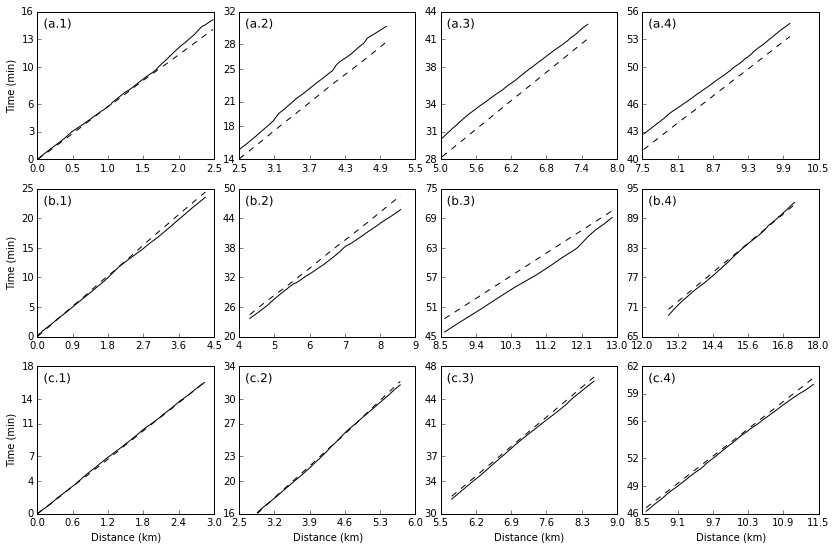

In [5]:
# REAL TIME VS PREDICTED TIME
fig = plt.figure(figsize=(14,9), dpi=72)
fb1 = fig.add_subplot(311)
divider = make_axes_locatable(fb1)
fb2 = divider.new_horizontal(size="100%", pad=0.35)
fb3 = divider.new_horizontal(size="100%", pad=0.35)
fb4 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = fb1.get_figure()
fig1.add_axes(fb2)
fig1.add_axes(fb3)
fig1.add_axes(fb4)

mf1 = fig.add_subplot(312)
divider = make_axes_locatable(mf1)
mf2 = divider.new_horizontal(size="100%", pad=0.35)
mf3 = divider.new_horizontal(size="100%", pad=0.35)
mf4 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = mf1.get_figure()
fig1.add_axes(mf2)
fig1.add_axes(mf3)
fig1.add_axes(mf4)

tst1 = fig.add_subplot(313)
divider = make_axes_locatable(tst1)
tst2 = divider.new_horizontal(size="100%", pad=0.35)
tst3 = divider.new_horizontal(size="100%", pad=0.35)
tst4 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = tst1.get_figure()
fig1.add_axes(tst2)
fig1.add_axes(tst3)
fig1.add_axes(tst4)

fb1.plot(feelingBad1['Distance']/1000, feelingBad1['Time Runner']/60, 'k', label='Race time')
fb1.plot(feelingBad1['Distance']/1000, feelingBad1['Total predicted']/60, 'k--', label='Predicted time')
fb2.plot(feelingBad2['Distance']/1000, feelingBad2['Time Runner']/60, 'k', label='Race time')
fb2.plot(feelingBad2['Distance']/1000, (feelingBad2['Total predicted'] + feelingBad1['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
fb3.plot(feelingBad3['Distance']/1000, feelingBad3['Time Runner']/60, 'k', label='Race time')
fb3.plot(feelingBad3['Distance']/1000, (feelingBad3['Total predicted'] + feelingBad1['Total predicted'].iloc[-1] + feelingBad2['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
fb4.plot(feelingBad4['Distance']/1000, feelingBad4['Time Runner']/60, 'k', label='Race time')
fb4.plot(feelingBad4['Distance']/1000, (feelingBad4['Total predicted'] + feelingBad1['Total predicted'].iloc[-1] + feelingBad2['Total predicted'].iloc[-1] + feelingBad3['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
fb1.set_ylabel('Time (min)')

mf1.plot(moratFribourg1['Distance']/1000, moratFribourg1['Time Runner']/60, 'k', label='Race time')
mf1.plot(moratFribourg1['Distance']/1000, moratFribourg1['Total predicted']/60, 'k--', label='Predicted time')
mf2.plot(moratFribourg2['Distance']/1000, moratFribourg2['Time Runner']/60, 'k', label='Race time')
mf2.plot(moratFribourg2['Distance']/1000, (moratFribourg2['Total predicted'] + moratFribourg1['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
mf3.plot(moratFribourg3['Distance']/1000, moratFribourg3['Time Runner']/60, 'k', label='Race time')
mf3.plot(moratFribourg3['Distance']/1000, (moratFribourg3['Total predicted'] + moratFribourg1['Total predicted'].iloc[-1] + moratFribourg2['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
mf4.plot(moratFribourg4['Distance']/1000, moratFribourg4['Time Runner']/60, 'k', label='Race time')
mf4.plot(moratFribourg4['Distance']/1000, (moratFribourg4['Total predicted'] + moratFribourg1['Total predicted'].iloc[-1] + moratFribourg2['Total predicted'].iloc[-1] + moratFribourg3['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')

mf1.set_ylabel('Time (min)')

tst1.plot(test1['Distance']/1000, test1['Time Runner']/60, 'k', label='Race time')
tst1.plot(test1['Distance']/1000, test1['Total predicted']/60, 'k--', label='Predicted time')
tst2.plot(test2['Distance']/1000, test2['Time Runner']/60, 'k', label='Race time')
tst2.plot(test2['Distance']/1000, (test2['Total predicted'] + test1['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
tst3.plot(test3['Distance']/1000, test3['Time Runner']/60, 'k', label='Race time')
tst3.plot(test3['Distance']/1000, (test3['Total predicted'] + test1['Total predicted'].iloc[-1] + test2['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')
tst4.plot(test4['Distance']/1000, test4['Time Runner']/60, 'k', label='Race time')
tst4.plot(test4['Distance']/1000, (test4['Total predicted'] + test1['Total predicted'].iloc[-1] + test2['Total predicted'].iloc[-1] + test3['Total predicted'].iloc[-1])/60, 'k--', label='Predicted time')

tst1.set_ylabel('Time (min)')

labels = np.concatenate([['(a.{})'.format(i+1) for i in range(4)], 
                         ['(b.{})'.format(i+1) for i in range(4)], 
                         ['(c.{})'.format(i+1) for i in range(4)]])

for ax, im_title in zip([fb1,fb2,fb3,fb4,mf1,mf2,mf3,mf4,tst1,tst2,tst3,tst4], labels):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.set_xticks(np.linspace(ax.get_xlim()[0],ax.get_xlim()[-1],num=6))
        ax.set_yticks(np.round(np.linspace(ax.get_ylim()[0],ax.get_ylim()[-1],num=6)))
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

tst1.set_xlabel('Distance (km)')
tst2.set_xlabel('Distance (km)')
tst3.set_xlabel('Distance (km)')
tst4.set_xlabel('Distance (km)')

plt.draw()
plt.show()
fig.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS5.pdf',bbox_inches='tight', dpi=fig.dpi)

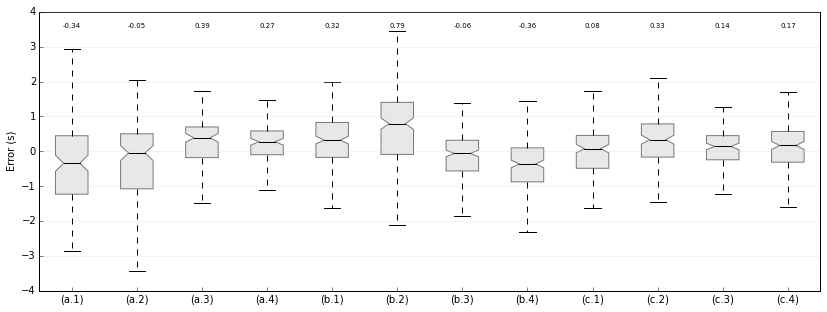

In [13]:
# BOXPLOTS ERRORES DE PREDICCIÓN
errorFeelingBad1 = feelingBad1['$\Delta{}t^{est}$'] - feelingBad1['$\Delta{}t^{real}$']
errorFeelingBad2 = feelingBad2['$\Delta{}t^{est}$'] - feelingBad2['$\Delta{}t^{real}$']
errorFeelingBad3 = feelingBad3['$\Delta{}t^{est}$'] - feelingBad3['$\Delta{}t^{real}$']
errorFeelingBad4 = feelingBad4['$\Delta{}t^{est}$'] - feelingBad4['$\Delta{}t^{real}$']
errorMoratFrib1 = moratFribourg1['$\Delta{}t^{est}$'] - moratFribourg1['$\Delta{}t^{real}$']
errorMoratFrib2 = moratFribourg2['$\Delta{}t^{est}$'] - moratFribourg2['$\Delta{}t^{real}$']
errorMoratFrib3 = moratFribourg3['$\Delta{}t^{est}$'] - moratFribourg3['$\Delta{}t^{real}$']
errorMoratFrib4 = moratFribourg4['$\Delta{}t^{est}$'] - moratFribourg4['$\Delta{}t^{real}$']
errorTest1 = test1['$\Delta{}t^{est}$'] - test1['$\Delta{}t^{real}$']
errorTest2 = test2['$\Delta{}t^{est}$'] - test2['$\Delta{}t^{real}$']
errorTest3 = test3['$\Delta{}t^{est}$'] - test3['$\Delta{}t^{real}$']
errorTest4 = test4['$\Delta{}t^{est}$'] - test4['$\Delta{}t^{real}$']

errors = [errorFeelingBad1, errorFeelingBad2, errorFeelingBad3, errorFeelingBad4,
          errorMoratFrib1, errorMoratFrib2, errorMoratFrib3, errorMoratFrib4,
          errorTest1, errorTest2, errorTest3, errorTest4]
labels = np.concatenate([['(a.{})'.format(i+1) for i in range(4)], 
                         ['(b.{})'.format(i+1) for i in range(4)], 
                         ['(c.{})'.format(i+1) for i in range(4)]])
numBoxes = len(errors)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(14,5), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(errors, labels=labels, patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')
ax.set_ylim([-4, 4])
top = ax.get_ylim()[1]*0.89
medians = [np.nanmedian(i) for i in errors]
upperLabels = [str(np.round(s, 2)) for s in medians]

for tick,label in zip(range(numBoxes),ax.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (s)')
fig.savefig('../../../Thesis/images/bxplotErrorsCS5.pdf',bbox_inches='tight', dpi=fig.dpi)

In [162]:
np.concatenate([['a{}'.format(i+1) for i in range(4)], ['b{}'.format(i+1) for i in range(4)], ['c{}'.format(i+1) for i in range(4)]])

array(['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3',
       'c4'], 
      dtype='|S2')

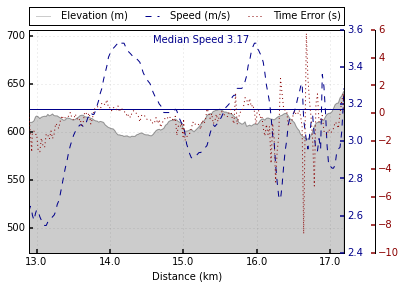

In [159]:
# GRAFICA DEL ERROR DE PREDICCION CON ELEVACION Y VELOCIDAD
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(moratFribourg4['Distance'], moratFribourg4['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
host.fill_between(moratFribourg4['Distance'], 0, moratFribourg4['Elevation'], color='k', alpha=0.2)
p2, = par1.plot(moratFribourg4['Distance'], moratFribourg4['Speed'], color='DarkBlue', linestyle='--', label='Speed (m/s)')
p2.axes.axhline(y=training_data.speed.median(), color='DarkBlue')
p3, = par2.plot(moratFribourg4['Distance'], moratFribourg4['$\Delta{}t^{est}$'] - moratFribourg4['$\Delta{}t^{real}$'], 
                color='DarkRed', linestyle=':', label=r'Time Error (s)')

host.set_xlim([moratFribourg4['Distance'].min(), moratFribourg4['Distance'].max()])
host.set_xticklabels(['{:.1f}'.format(i) for i in host.get_xticks()/1000])
host.set_ylim([moratFribourg4['Elevation'].min()*0.8, moratFribourg4['Elevation'].max()*1.1])

host.set_xlabel(r'Distance (km)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()
host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.97*(host.get_xlim()[-1] + host.get_xlim()[0]) / 2, 0.98*host.get_ylim()[-1],
          'Median Speed {:.2f}'.format(training_data.speed.median()), color='DarkBlue', fontsize=10)
fig.savefig("../../../Thesis/images/errorCS5MorFrib4.pdf", bbox_inches='tight', dpi=fig.dpi)